In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
np.set_printoptions(suppress=True)

In [2]:
df_sub = pd.read_pickle('subscribers')

In [3]:
df_eng = pd.read_pickle('engagement')

In [4]:
df_cus = pd.read_pickle('customer_service_reps')

# customer segamentation

In [142]:
#select columns we need
df1 = df_sub[['subid','weekly_consumption_hour','age','package_type','preferred_genre','join_fee']]

In [143]:
#deal with the age
for i in range(len(df1)):
    if len(str(int(df1.iloc[i,2]))) == 3:
        df1.iloc[i,2] = 100
    elif df1.iloc[i,2]>1600 and df1.iloc[i,2]<2021:
        df1.iloc[i,2] = 2020 - df1.iloc[i,2]
    elif len(str(int(df1.iloc[i,2]))) >= 4:
        df1.iloc[i,2] = 100
    elif df1.iloc[i,2] < 12:
        df1.iloc[i,2] = 12

F:\Users\Hanshunfan\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [146]:
#deal with the nan
df1['package_type'].fillna(value='other_package',inplace = True)
df1['preferred_genre'].fillna(value='other',inplace = True)

In [149]:
#create dummy variable for string
df1 = df1.join(pd.get_dummies(df1.package_type))
df1 = df1.join(pd.get_dummies(df1.preferred_genre))

#drop columns we dont need
df1.drop(['package_type','preferred_genre'],axis = 1,inplace = True)
df1.drop(['economy','enhance','drama','international','regional'],axis = 1,inplace = True)

In [156]:
#delet subid
df1_input = df1.drop('subid',axis = 1)
df1_input.head()

,subid,weekly_consumption_hour,age,join_fee,base,other_package,comedy,other
162502,21724479,0.000000,12.0,0.0000,0,0,1,0
380374,23383224,22.951579,70.0,0.3303,1,0,1,0
496617,26844789,36.001186,25.0,0.1101,0,0,0,0
356799,29417030,20.051667,30.0,0.0367,1,0,0,0
681701,26723159,22.951579,28.0,0.0367,1,0,1,0


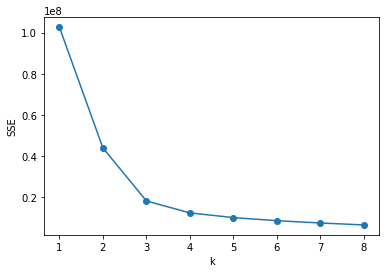

<Figure size 432x288 with 0 Axes>

In [218]:
#elbo test
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
SSE = []
for k in range(1, 9):
    estimator = KMeans(n_clusters=k)
    estimator.fit(df1_input)
    SSE.append(estimator.inertia_)
X = range(1, 9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')
plt.show()

plt.savefig('./elbow.jpg', dpi=1000)

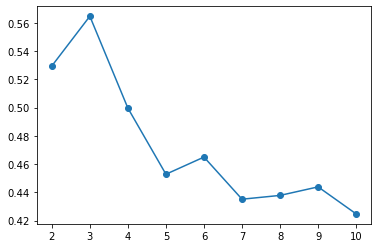

In [219]:
#silhouette_score
from sklearn.metrics import silhouette_score

index = []
silhouette = []
sample = df1_input.sample(n=5000)
for i in range(9):
    model = KMeans(n_clusters=i+2)
    model.fit(sample)
    index.append(i+2)
    silhouette.append(silhouette_score(sample, model.labels_))
    
plt.plot(index, silhouette, '-o')
plt.savefig('./silhourtte.jpg', dpi=1000)

In [160]:
#weekly_consum,age,join_fee,base,other_package,comedy,other
#df1_input = df1.drop('subid',axis = 1)
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit_predict(df1_input)
kmeans_model.cluster_centers_

array([[27.33121379, 58.11509704,  0.13903124,  0.48160124,  0.19057018,
         0.47257247,  0.21558829],
       [28.14215644, 34.67090936,  0.09199227,  0.42929912,  0.17340998,
         0.54585525,  0.19598935],
       [ 0.01879963, 12.55456983,  0.00274466,  0.67144792,  0.02047923,
         0.76301025,  0.02335351]])

In [170]:
#result
r1 = pd.Series(kmeans_model.labels_).value_counts()
r3=kmeans_model.labels_
r2 = pd.DataFrame(kmeans_model.cluster_centers_)
r4=kmeans_model.cluster_centers_
r = pd.concat([r2, r1], axis = 1)
r.columns = list(df1_input.columns)+ [u'class']
print(r)

   weekly_consumption_hour        age  join_fee      base  other_package  \
0                27.331214  58.115097  0.139031  0.481601       0.190570   
1                28.142156  34.670909  0.091992  0.429299       0.173410   
2                 0.018800  12.554570  0.002745  0.671448       0.020479   

     comedy     other  class  
0  0.472572  0.215588  95284  
1  0.545855  0.195989  96161  
2  0.763010  0.023354  36183  


In [221]:
#vision
df_test = df1_input
df_test['label'] = kmeans_model.fit_predict(df1_input)
df_test.head()

,weekly_consumption_hour,age,join_fee,base,other_package,comedy,other,label
162502,0.000000,12.0,0.0000,0,0,1,0,2
380374,22.951579,70.0,0.3303,1,0,1,0,0
496617,36.001186,25.0,0.1101,0,0,0,0,1
356799,20.051667,30.0,0.0367,1,0,0,0,1
681701,22.951579,28.0,0.0367,1,0,1,0,1


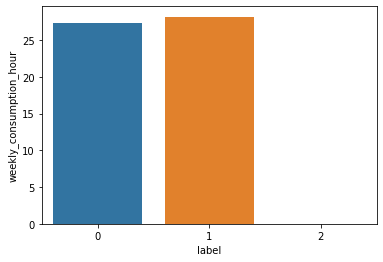

In [225]:
import seaborn as sns
#sns.barplot(x='label',y='weekly_consumption_hour',data=df_test)
#sns.barplot(x='label',y='age',data=df_test)
#sns.barplot(x='label',y='join_fee',data=df_test)

# customer segamentation PCA(just a look,the result is the same)

In [207]:
#background
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sea
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [227]:
df2 = df_sub[['subid','weekly_consumption_hour','age','package_type','preferred_genre','join_fee']]

In [229]:
#deal with the age
for i in range(len(df2)):
    if len(str(int(df2.iloc[i,2]))) == 3:
        df2.iloc[i,2] = 100
    elif df2.iloc[i,2]>1600 and df2.iloc[i,2]<2021:
        df2.iloc[i,2] = 2020- df2.iloc[i,2]
    elif len(str(int(df2.iloc[i,2]))) >= 4:
        df2.iloc[i,2] = 100
    elif df2.iloc[i,2] < 12:
        df2.iloc[i,2] = 12

F:\Users\Hanshunfan\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [240]:
df2_input = df2.drop('subid',axis = 1)
df2_input.head()

,weekly_consumption_hour,age,join_fee,base,economy,enhanced,other_package,comedy,drama,international,other,regional
162502,0.000000,12.0,0.0000,0,1,0,0,1,0,0,0,0
380374,22.951579,70.0,0.3303,1,0,0,0,1,0,0,0,0
496617,36.001186,25.0,0.1101,0,0,1,0,0,0,0,0,1
356799,20.051667,30.0,0.0367,1,0,0,0,0,1,0,0,0
681701,22.951579,28.0,0.0367,1,0,0,0,1,0,0,0,0


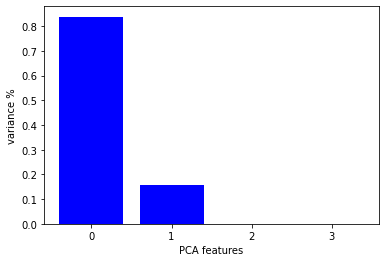

In [235]:
#PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df2_input)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

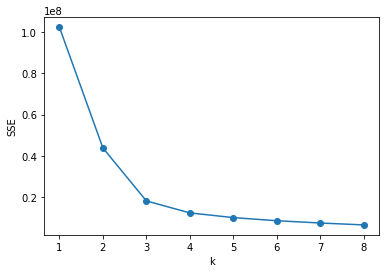

<Figure size 432x288 with 0 Axes>

In [236]:
#elbow again
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
SSE = []
for k in range(1, 9):
    estimator = KMeans(n_clusters=k)
    estimator.fit(PCA_components.iloc[:,:2])
    SSE.append(estimator.inertia_)
X = range(1, 9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')
plt.show()

plt.savefig('./elbow.jpg', dpi=1000)

In [241]:
#predict with pca
kmeans_model2 = KMeans(n_clusters=3)
df2_input['label'] = kmeans_model2.fit_predict(PCA_components.iloc[:,:2])

In [249]:
#result is the same
avg_df = df2_input.groupby(['label'], as_index=False).mean()
avg_df

,label,weekly_consumption_hour,age,join_fee,base,economy,enhanced,other_package,comedy,drama,international,other,regional
0,0,0.018800,12.554570,0.002745,0.671448,0.037421,0.270652,0.020479,0.763010,0.188348,0.009341,0.023354,0.015947
1,1,28.136821,34.666678,0.091977,0.429280,0.059692,0.337632,0.173397,0.545918,0.174624,0.025177,0.195973,0.058308
2,2,27.336879,58.111248,0.139031,0.481602,0.107626,0.220194,0.190578,0.472535,0.244165,0.038254,0.215598,0.029449


# allocation

In [6]:
#channel_spend_graduate table
df_cha = pd.read_csv('channel_spend_graduate.csv')
df_cha.head()

,channel,date,spend_AED
0,bing,201907,400
1,display,201907,12
2,facebook,201907,9000
3,search,201907,13000
4,youtube,201907,90


In [16]:
df_sub_csv = pd.read_csv('subscribers.csv')
df_sub_csv.drop('Unnamed: 0',axis = 1,inplace = True)
df_sub_csv.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [81]:
#detail data from subscribers
df_det = df_sub_csv[['attribution_technical','account_creation_date', 'payment_period']]

#deal with the data format
def time_transform(timestr):
    timeback = timestr[0:4]+timestr[5:7]
    return timeback

df_det['account_creation_date'] = df_det['account_creation_date'].map(lambda x: time_transform(str(x)))
df_sub['account_creation_date'] = df_sub['account_creation_date'].map(lambda x: time_transform(str(x)))
#df_sub['revenue_net'].fillna(value=0,inplace = True)
#df_det.fillna(value = 0,inplace = True)

<ipython-input-81-8d352a415625>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det['account_creation_date'] = df_det['account_creation_date'].map(lambda x: time_transform(str(x)))


In [127]:
#prepare user number
channel_list = list(df_cha['channel'].unique())
date_list = list(df_cha['date'].unique())
customer_set = {}
for d in date_list:
    customer_set[str(d)]={x:0 for x in channel_list}

for i in df_det.index:
    if (df_det.loc[i, 'attribution_technical'] in channel_list)&(int(df_det.loc[i, 'account_creation_date']) in date_list):
        customer_set[df_det.loc[i,'account_creation_date']][df_det.loc[i,'attribution_technical']] += 1
        
df_customer_set = pd.DataFrame(customer_set)
df_customer_set

,201907,201908,201909,201910,201911,201912,202001,202002
bing,120,71,84,86,103,28,172,303
display,44,74,12,50,90,112,536,341
facebook,10011,9855,6129,9489,12995,9288,6289,7988
search,1328,1939,1852,2333,2510,3770,4073,4300
youtube,8,15,2,11,47,76,370,205


In [126]:
#prepare users'revenue
revenue_set = {}

for d in date_list:
    revenue_set[str(d)]={x:0 for x in channel_list}
df_revenue_set = pd.DataFrame(revenue_set)

for i in df_revenue_set.columns:
    for j in df_revenue_set.index:
        df = df_sub[df_sub['attribution_technical']==j]
        df_revenue_set.loc[j,i] = df[df['account_creation_date']==i]['revenue_net'].sum()
df_revenue_set

,201907,201908,201909,201910,201911,201912,202001,202002
bing,320.9048,116.4491,207.9055,172.3799,198.2534,41.1040,344.4662,524.2962
display,155.8282,179.6832,66.0600,184.3441,248.8260,273.8921,1095.0546,563.9689
facebook,24153.0407,11116.3566,3598.8754,5137.1926,7650.2618,4745.6403,3036.8883,3943.4150
search,2789.8973,3125.7390,2225.0476,2692.8258,2979.4161,4324.6546,4609.1163,3847.2610
youtube,4.8444,32.7364,9.1750,18.3500,78.4279,126.5416,440.7670,256.6064


In [94]:
#prepare spend table
spend_set = {}
for i in date_list:
    spend_set[str(i)]={x:0 for x in channel_list}
for j in df_cha.index:
    spend_set[str(df_cha.loc[j,'date'])][df_cha.loc[j, 'channel']] = df_cha.loc[j, 'spend_AED']
    
df_spend_set = pd.DataFrame(spend_set)
df_spend_set

,201907,201908,201909,201910,201911,201912,202001,202002
bing,400,900,1000,1100,1300,300,2100,3700
display,12,20,13,19,29,31,148,94
facebook,9000,13000,10500,17000,23000,16000,11000,14000
search,13000,18500,19000,24000,25000,38000,41000,44000
youtube,90,180,100,130,550,900,4360,2420


In [128]:
#save the result
cac = df_spend_set.div(df_customer_set).round(2)
cac.to_excel('cac.xls')

clv = df_revenue_set.div(df_customer_set).round(2)
clv.to_excel('clv.xls')

In [129]:
cac

,201907,201908,201909,201910,201911,201912,202001,202002
bing,3.33,12.68,11.90,12.79,12.62,10.71,12.21,12.21
display,0.27,0.27,1.08,0.38,0.32,0.28,0.28,0.28
facebook,0.90,1.32,1.71,1.79,1.77,1.72,1.75,1.75
search,9.79,9.54,10.26,10.29,9.96,10.08,10.07,10.23
youtube,11.25,12.00,50.00,11.82,11.70,11.84,11.78,11.80


In [130]:
clv

,201907,201908,201909,201910,201911,201912,202001,202002
bing,2.67,1.64,2.48,2.00,1.92,1.47,2.00,1.73
display,3.54,2.43,5.50,3.69,2.76,2.45,2.04,1.65
facebook,2.41,1.13,0.59,0.54,0.59,0.51,0.48,0.49
search,2.10,1.61,1.20,1.15,1.19,1.15,1.13,0.89
youtube,0.61,2.18,4.59,1.67,1.67,1.67,1.19,1.25


# Churn

In [128]:
df_sub_csv = pd.read_csv('subscribers.csv')
df_sub_csv.drop('Unnamed: 0',axis = 1,inplace = True)
df_sub_csv.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [129]:
#delet cols we do not need
drop_col_list = ['subid','country','months_per_bill_period','account_creation_date','trial_end_date','language','last_payment','next_payment','cancel_date','attribution_survey']
df_sub_csv.drop(drop_col_list,axis = 1,inplace = True)

In [130]:
#deal with nan
df_sub_csv['package_type'].fillna(value = 'other_package_type',inplace = True)
df_sub_csv['num_weekly_services_utilized'].fillna(value = 3,inplace = True)
df_sub_csv['preferred_genre'].fillna(value = 'other',inplace = True)
df_sub_csv['intended_use'].fillna(value = 'other',inplace = True)
df_sub_csv['weekly_consumption_hour'].fillna(value = 27,inplace = True)
df_sub_csv['num_ideal_streaming_services'].fillna(value = 2,inplace = True)
df_sub_csv['age'].fillna(value = 18,inplace = True)
df_sub_csv['male_TF'].fillna(value = False,inplace = True)
df_sub_csv['op_sys'].fillna(value = 'iOS',inplace = True)
df_sub_csv['join_fee'].fillna(value = 0.115145,inplace = True)
df_sub_csv['payment_type'].fillna(value ='Standard Charter',inplace = True)


In [131]:
#deal with the age
for i in range(len(df_sub_csv)):
    if len(str(int(df_sub_csv.iloc[i,6]))) == 3:
        df_sub_csv.iloc[i,6] = 100
    elif df_sub_csv.iloc[i,6]>1600 and df_sub_csv.iloc[i,6]<2021:
        df_sub_csv.iloc[i,6] = 2020 - df_sub_csv.iloc[i,6]
    elif len(str(int(df_sub_csv.iloc[i,6]))) >= 4:
        df_sub_csv.iloc[i,6] = 100
    elif df_sub_csv.iloc[i,6] < 12:
        df_sub_csv.iloc[i,6] = 12

### PCA

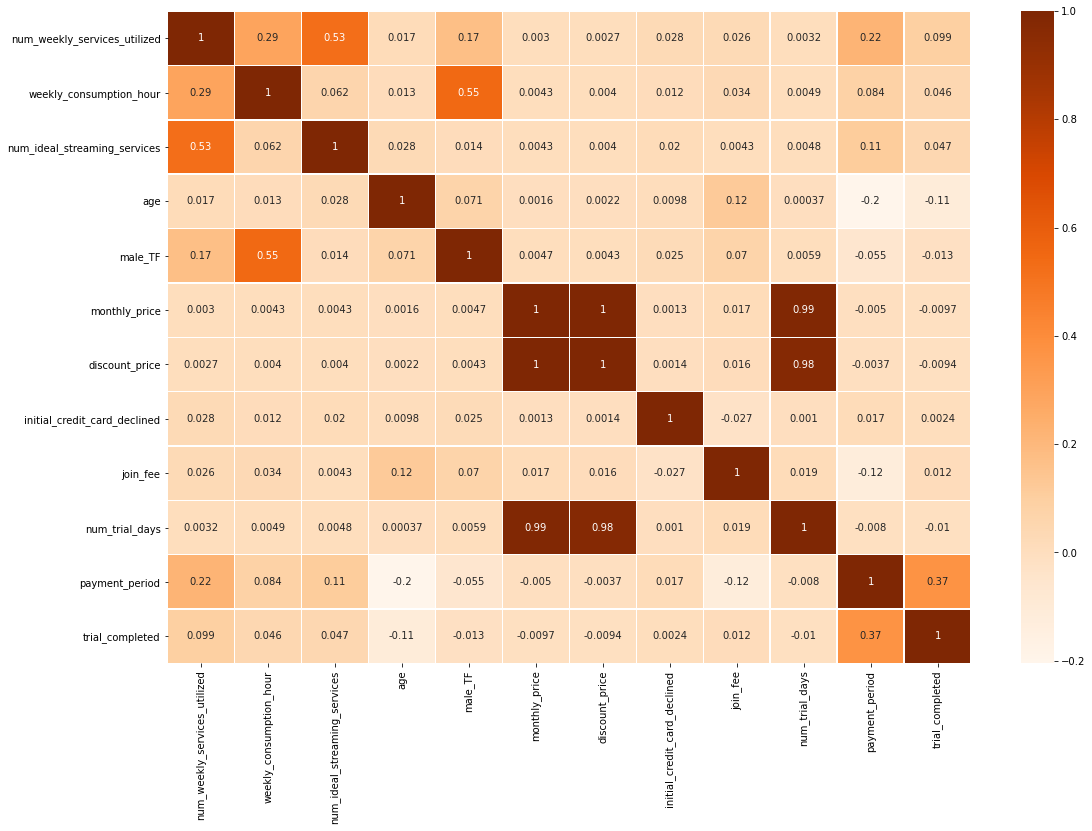

In [132]:
#see the col between features, we will combine simliar feature during the pca move
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

user_features=list(df_sub_csv.columns)
user_features.remove('current_sub_TF')

corr_mat=df_sub_csv[user_features].corr()
 
fig,ax = plt.subplots(figsize=(18, 12))
sns.heatmap(corr_mat, xticklabels=True, yticklabels=True, square=False, linewidths=.5, annot=True, cmap='Oranges')
plt.savefig('feature_col.jpg',dpi=1000, bbox_inches='tight')

In [133]:
#use an another test set to test the pca effect
df_test = df_sub_csv

In [134]:
usage = ['num_weekly_services_utilized','num_ideal_streaming_services']
hour = ['weekly_consumption_hour','male_TF']
price = ['monthly_price','discount_price','num_trial_days']
trial = ['payment_period','trial_completed']

In [135]:
#PCA method
from sklearn.decomposition import PCA
pca=PCA(n_components=1)
df_test['usage']=pca.fit_transform(df_test[usage])
df_test['hour']=pca.fit_transform(df_test[hour])
df_test['price']=pca.fit_transform(df_test[price])
df_test['trial']=pca.fit_transform(df_test[trial])
 
df_test.drop(usage,axis=1,inplace=True)
df_test.drop(hour,axis=1,inplace=True)
df_test.drop(price,axis=1,inplace=True)
df_test.drop(trial,axis=1,inplace=True)


In [137]:
#replace those others
df_test['preferred_genre'].replace('other','other_genre',inplace = True)
df_test['intended_use'].replace('other','other_intended_use',inplace = True)
df_test['attribution_technical'].replace('other','other_attribution_technical',inplace = True)
#df_test['attribution_survey'].replace('other','other_attribution_survey',inplace = True)


In [138]:
#get dummy
dummy_list = ['package_type','preferred_genre','intended_use','attribution_technical','op_sys','plan_type','initial_credit_card_declined','payment_type']
df_test = df_test.join(pd.get_dummies(df_test.package_type))
df_test = df_test.join(pd.get_dummies(df_test.preferred_genre))
df_test = df_test.join(pd.get_dummies(df_test.intended_use))
df_test = df_test.join(pd.get_dummies(df_test.attribution_technical))
df_test = df_test.join(pd.get_dummies(df_test.op_sys))
df_test = df_test.join(pd.get_dummies(df_test.plan_type))
df_test = df_test.join(pd.get_dummies(df_test.initial_credit_card_declined))
df_test = df_test.join(pd.get_dummies(df_test.payment_type))

df_test.drop(dummy_list,axis=1,inplace=True)

### Predict with PCA method

In [141]:
# standardlize
from sklearn.preprocessing import StandardScaler
 
y=df_test['current_sub_TF']
x=df_test.drop('current_sub_TF',axis=1)
 
scaler = StandardScaler()
scaler.fit(x)
 
X= scaler.transform(x)

F:\Users\Hanshunfan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
F:\Users\Hanshunfan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [142]:
#split the data
from sklearn.model_selection import train_test_split, GridSearchCV
 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.2,random_state=404)

In [189]:
#logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
 
lr = LogisticRegression()                                        
lr.fit(X_train,y_train)                                         
y_prob = lr.predict_proba(X_test)[:,1]                           
y_pred = lr.predict(X_test)                                     
fpr_lr,tpr_lr,threshold_lr = metrics.roc_curve(y_test,y_prob)    
auc_lr = metrics.auc(fpr_lr,tpr_lr)                              
score_lr = metrics.accuracy_score(y_test,y_pred)                 
print('Accuracy:{0},AUC score:{1}'.format(score_lr,auc_lr))
print('============================================================')
print(classification_report(y_test,y_pred,labels=None,target_names=None,sample_weight=None, digits=2))

Accuracy:0.934015727276721,AUC score:0.9795735765158807
              precision    recall  f1-score   support

       False       0.93      0.92      0.92     19605
        True       0.94      0.95      0.94     25921

    accuracy                           0.93     45526
   macro avg       0.93      0.93      0.93     45526
weighted avg       0.93      0.93      0.93     45526



In [164]:
#naive_bayes
from sklearn.naive_bayes import GaussianNB
 
gnb = GaussianNB()                                                
gnb.fit(X_train,y_train)                                          
y_prob = gnb.predict_proba(X_test)[:,1]                           
y_pred = gnb.predict(X_test)                                      
fpr_gnb,tpr_gnb,threshold_gnb = metrics.roc_curve(y_test,y_prob)  
auc_gnb = metrics.auc(fpr_gnb,tpr_gnb)                            
score_gnb = metrics.accuracy_score(y_test,y_pred)                 
  
print('Accuracy:{0},AUC score:{1}'.format(score_gnb,auc_gnb))
print('============================================================')
print(classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2))

Accuracy:0.7730307955893335,AUC score:0.9131988106486544
              precision    recall  f1-score   support

       False       0.86      0.57      0.68     19605
        True       0.74      0.93      0.82     25921

    accuracy                           0.77     45526
   macro avg       0.80      0.75      0.75     45526
weighted avg       0.79      0.77      0.76     45526



In [166]:
#SVC
from sklearn.svm import SVC
 
svc = SVC(kernel='rbf',C=1,max_iter=100).fit(X_train,y_train)
y_prob = svc.decision_function(X_test)                              
y_pred = svc.predict(X_test)                                        
fpr_svc,tpr_svc,threshold_svc = metrics.roc_curve(y_test,y_prob)    
auc_svc = metrics.auc(fpr_svc,tpr_svc)                              
score_svc = metrics.accuracy_score(y_test,y_pred)

print('Accuracy:{0},AUC score:{1}'.format(score_svc,auc_svc))
print('============================================================')
print(classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2))

F:\Users\Hanshunfan\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy:0.5848745771646972,AUC score:0.9188410411597179
              precision    recall  f1-score   support

       False       0.51      0.98      0.67     19605
        True       0.95      0.29      0.44     25921

    accuracy                           0.58     45526
   macro avg       0.73      0.63      0.55     45526
weighted avg       0.76      0.58      0.54     45526



In [167]:
#decision tree
from sklearn import tree
 
dtc = tree.DecisionTreeClassifier()                              
dtc.fit(X_train,y_train)                                         
y_prob = dtc.predict_proba(X_test)[:,1]                          
y_pred = dtc.predict(X_test)                                     
fpr_dtc,tpr_dtc,threshod_dtc= metrics.roc_curve(y_test,y_prob)   
score_dtc = metrics.accuracy_score(y_test,y_pred)                
auc_dtc = metrics.auc(fpr_dtc,tpr_dtc)

print('Accuracy:{0},AUC score:{1}'.format(score_dtc,auc_dtc))
print('============================================================')
print(classification_report(y_test,y_pred,labels=None,target_names=None,sample_weight=None, digits=2))

Accuracy:0.9103369503141062,AUC score:0.9123661184990106
              precision    recall  f1-score   support

       False       0.90      0.90      0.90     19605
        True       0.92      0.92      0.92     25921

    accuracy                           0.91     45526
   macro avg       0.91      0.91      0.91     45526
weighted avg       0.91      0.91      0.91     45526



In [171]:
#random forest
from sklearn.ensemble import RandomForestClassifier
 
rfc = RandomForestClassifier()                                     
rfc.fit(X_train,y_train)                                           
y_prob = rfc.predict_proba(X_test)[:,1]                            
y_pred=rfc.predict(X_test)                                         
fpr_rfc,tpr_rfc,threshold_rfc = metrics.roc_curve(y_test,y_prob)   
auc_rfc = metrics.auc(fpr_rfc,tpr_rfc)                             
score_rfc = metrics.accuracy_score(y_test,y_pred)     

print('Accuracy:{0},AUC score:{1}'.format(score_rfc,auc_rfc))
print('============================================================')
print(classification_report(y_test,y_pred,labels=None,target_names=None,sample_weight=None, digits=2))

Accuracy:0.9349163115582304,AUC score:0.9778770733955027
              precision    recall  f1-score   support

       False       0.93      0.92      0.92     19605
        True       0.94      0.95      0.94     25921

    accuracy                           0.93     45526
   macro avg       0.93      0.93      0.93     45526
weighted avg       0.93      0.93      0.93     45526



In [169]:
#xgbt
import xgboost as xgb
 
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test)

params={'booster':'gbtree','objective': 'binary:logistic','eval_metric': 'auc',
    'max_depth':8,'gamma':0,'lambda':2,'subsample':0.7,'colsample_bytree':0.8,
    'min_child_weight':3,'eta': 0.2,'nthread':8,'silent':1}
 
watchlist = [(dtrain,'train')]
bst=xgb.train(params,dtrain,num_boost_round=1000,evals=watchlist)
 
y_prob=bst.predict(dtest)
 
#threshold    
y_pred = (y_prob >= 0.5)*1
 
fpr_xgb,tpr_xgb,threshold_xgb = metrics.roc_curve(y_test,y_prob)   
auc_xgb = metrics.auc(fpr_xgb,tpr_xgb)    
score_xgb = metrics.accuracy_score(y_test,y_pred)    
print('Accuracy:{0},AUC score:{1}'.format(score_xgb,auc_xgb))
print('============================================================')
print(classification_report(y_test,y_pred,labels=None,target_names=None,sample_weight=None, digits=2))

[15:53:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.89060
[1]	train-auc:0.97119
[2]	train-auc:0.97492
[3]	train-auc:0.97387
[4]	train-auc:0.97846
[5]	train-auc:0.97760
[6]	train-auc:0.97876
[7]	train-auc:0.98089
[8]	train-auc:0.98069
[9]	train-auc:0.98199
[10]	train-auc:0.98290
[11]	train-auc:0.98374
[12]	train-auc:0.98396
[13]	train-auc:0.98447
[14]	train-auc:0.98477
[15]	train-auc:0.98505
[16]	train-auc:0.98515
[17]	train-auc:0.98541
[18]	train-auc:0.98553
[19]	train-auc:0.98566
[20]	train-auc:0.98579
[21]	train-auc:0.98592
[22]	train-auc:0.98605
[23]	train-auc:0.98614
[24]	train-auc:0.98623
[25]	train-auc:0.986

[329]	train-auc:0.99257
[330]	train-auc:0.99257
[331]	train-auc:0.99258
[332]	train-auc:0.99259
[333]	train-auc:0.99259
[334]	train-auc:0.99261
[335]	train-auc:0.99263
[336]	train-auc:0.99264
[337]	train-auc:0.99264
[338]	train-auc:0.99264
[339]	train-auc:0.99266
[340]	train-auc:0.99267
[341]	train-auc:0.99268
[342]	train-auc:0.99268
[343]	train-auc:0.99269
[344]	train-auc:0.99270
[345]	train-auc:0.99271
[346]	train-auc:0.99271
[347]	train-auc:0.99272
[348]	train-auc:0.99272
[349]	train-auc:0.99273
[350]	train-auc:0.99275
[351]	train-auc:0.99276
[352]	train-auc:0.99277
[353]	train-auc:0.99278
[354]	train-auc:0.99278
[355]	train-auc:0.99280
[356]	train-auc:0.99281
[357]	train-auc:0.99282
[358]	train-auc:0.99283
[359]	train-auc:0.99284
[360]	train-auc:0.99285
[361]	train-auc:0.99286
[362]	train-auc:0.99287
[363]	train-auc:0.99288
[364]	train-auc:0.99288
[365]	train-auc:0.99289
[366]	train-auc:0.99291
[367]	train-auc:0.99292
[368]	train-auc:0.99293
[369]	train-auc:0.99295
[370]	train-auc:

[671]	train-auc:0.99509
[672]	train-auc:0.99509
[673]	train-auc:0.99510
[674]	train-auc:0.99510
[675]	train-auc:0.99512
[676]	train-auc:0.99512
[677]	train-auc:0.99513
[678]	train-auc:0.99513
[679]	train-auc:0.99514
[680]	train-auc:0.99513
[681]	train-auc:0.99514
[682]	train-auc:0.99515
[683]	train-auc:0.99516
[684]	train-auc:0.99516
[685]	train-auc:0.99516
[686]	train-auc:0.99519
[687]	train-auc:0.99521
[688]	train-auc:0.99520
[689]	train-auc:0.99521
[690]	train-auc:0.99523
[691]	train-auc:0.99522
[692]	train-auc:0.99523
[693]	train-auc:0.99524
[694]	train-auc:0.99525
[695]	train-auc:0.99525
[696]	train-auc:0.99525
[697]	train-auc:0.99527
[698]	train-auc:0.99528
[699]	train-auc:0.99528
[700]	train-auc:0.99528
[701]	train-auc:0.99529
[702]	train-auc:0.99529
[703]	train-auc:0.99529
[704]	train-auc:0.99530
[705]	train-auc:0.99530
[706]	train-auc:0.99531
[707]	train-auc:0.99531
[708]	train-auc:0.99531
[709]	train-auc:0.99532
[710]	train-auc:0.99532
[711]	train-auc:0.99533
[712]	train-auc:

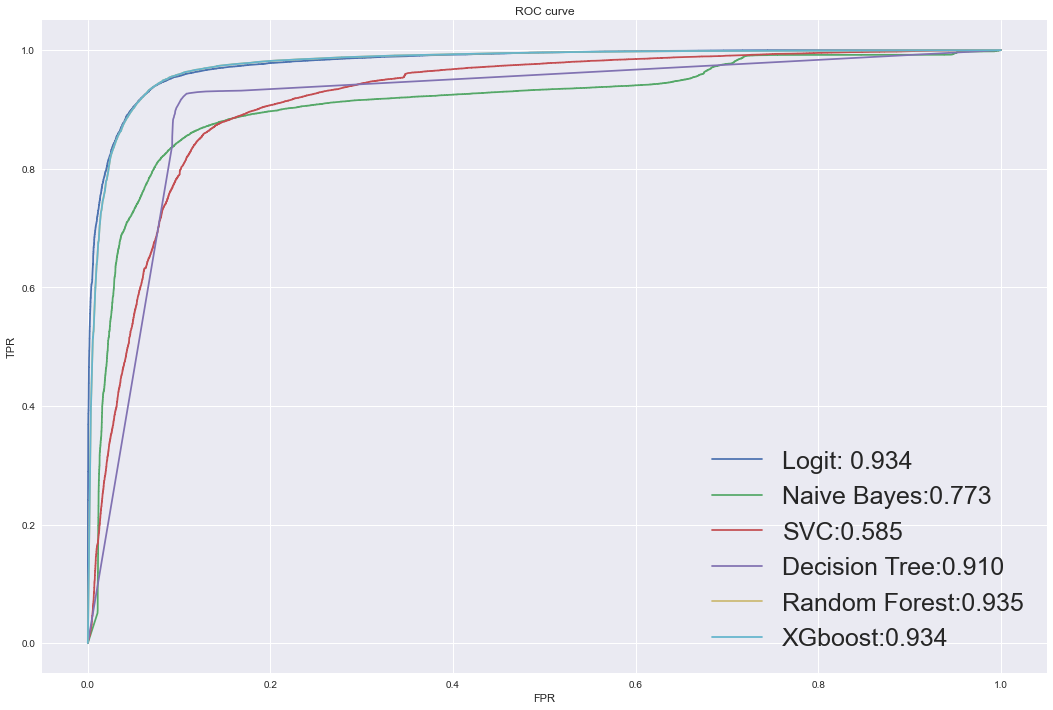

In [172]:
#ROC curve
plt.style.use('seaborn')
plt.figure(figsize=(18,12))
 
plt.plot(fpr_lr,tpr_lr,label='Logit: {0:.3f}'.format(score_lr))           
plt.plot(fpr_gnb,tpr_gnb,label='Naive Bayes:{0:.3f}'.format(score_gnb))         
plt.plot(fpr_svc,tpr_svc,label='SVC:{0:.3f}'.format(score_svc))         
plt.plot(fpr_dtc,tpr_dtc,label='Decision Tree:{0:.3f}'.format(score_dtc))         
plt.plot(fpr_rfc,tpr_rfc,label='Random Forest:{0:.3f}'.format(score_rfc))         
plt.plot(fpr_rfc,tpr_rfc,label='XGboost:{0:.3f}'.format(score_xgb))         
 
plt.legend(loc='lower right',prop={'size':25})
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.savefig('ROC curve.jpg',dpi=1000, bbox_inches='tight')
plt.show()

In [178]:
col_name

['age',
 'join_fee',
 'usage',
 'hour',
 'price',
 'trial',
 'base',
 'economy',
 'enhanced',
 'other_package_type',
 'comedy',
 'drama',
 'international',
 'other_genre',
 'regional',
 'access to exclusive content',
 'education',
 'expand international access',
 'expand regional access',
 'other_intended_use',
 'replace OTT',
 'supplement OTT',
 'affiliate',
 'appstore',
 'bing',
 'bing_organic',
 'brand sem intent bing',
 'brand sem intent google',
 'content_greatist',
 'criteo',
 'direct_mail',
 'discovery',
 'display',
 'email',
 'email_blast',
 'facebook',
 'facebook_organic',
 'google_organic',
 'influencer',
 'internal',
 'organic',
 'other_attribution_technical',
 'ott',
 'pinterest',
 'pinterest_organic',
 'playstore',
 'podcast',
 'quora',
 'referral',
 'samsung',
 'search',
 'tv',
 'twitter',
 'vod',
 'youtube',
 'Android',
 'iOS',
 'base_eur_14_day_trial',
 'base_uae_14_day_trial',
 'base_uae_no_trial_7_day_guarantee',
 'high_aud_14_day_trial',
 'high_jpy_14_day_trial',
 'h

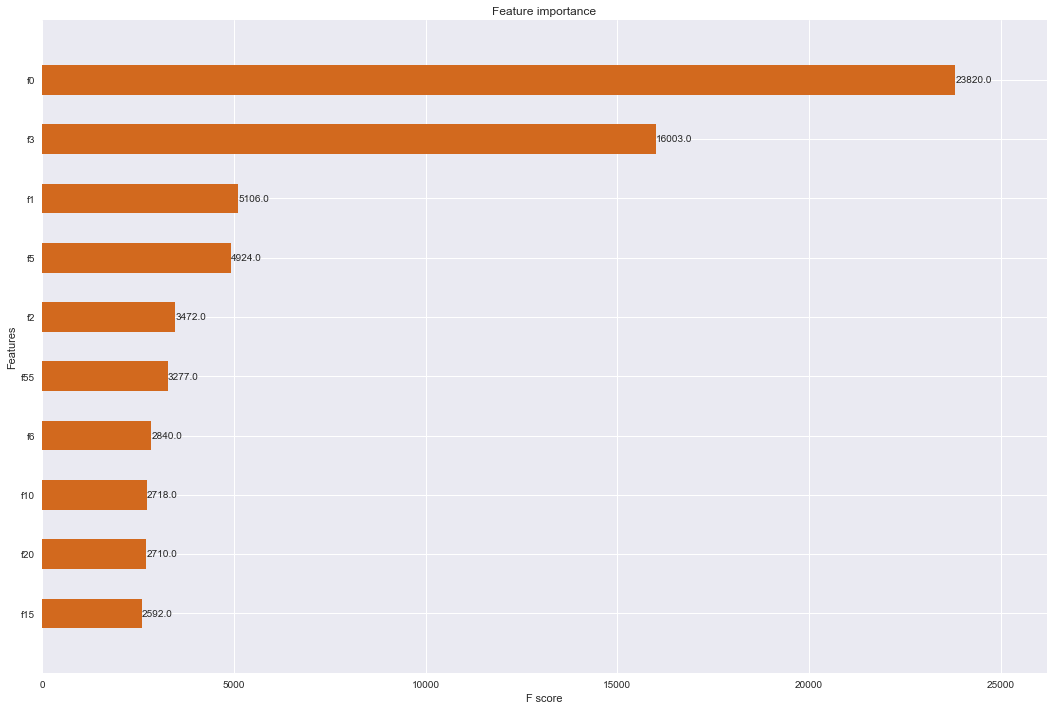

In [182]:
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(18,12))
plot_importance(bst,height=0.5,ax=ax,max_num_features=10,color='chocolate')
plt.savefig('important feature.jpg',dpi=1000, bbox_inches='tight')
plt.show()

### revenue lift

In [219]:
lift_test = df_test.drop('current_sub_TF',axis=1)
scaler = StandardScaler()
scaler.fit(lift_test )
lift_test = scaler.transform(lift_test)
lift_test_xgbt = xgb.DMatrix(lift_test)

F:\Users\Hanshunfan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
F:\Users\Hanshunfan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [221]:
df_lift_test = pd.DataFrame(lift_test)
df_lift_test['prob_churn_xgbt'] = bst.predict(lift_test_xgbt)
df_lift_test['prob_churn_logit'] = lr.predict_proba(lift_test)[:,1]   
df_lift_test = df_lift_test[['prob_churn_xgbt','prob_churn_logit']]
df_lift_test = pd.concat([df_lift_test,df_test['current_sub_TF']],axis=1)

In [222]:
df_lift_test.rename(columns={'current_sub_TF':'churn_TF'},inplace = True)
df_lift_test['churn_TF'].replace(True,1,inplace = True)
df_lift_test['churn_TF'].replace(False,0,inplace = True)
df_lift_test.head()

,prob_churn_xgbt,prob_churn_logit,churn_TF
0,0.914741,0.931593,1.0
1,0.999942,0.942762,1.0
2,0.089132,0.147714,0.0
3,0.020088,0.027941,0.0
4,0.999521,0.997104,1.0


In [208]:
#apply_offers function
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_xgbt'] = (df_f['prob_churn_xgbt'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_xgbt'] = (df_f['make_offer_xgbt'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_xgbt_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_xgbt'], 'price_xgbt_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

In [223]:
import copy
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'xgbt_offer', 'logit_offer']

In [224]:
# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_lift_test['random_draws'] = np.random.random(df_lift_test.shape[0])

In [225]:
# base assessment
df_test, df_impact = apply_offers(df_lift_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

#take 3000 sample
df_test_sample = df_test.sample(3000)

In [234]:
# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test_sample, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

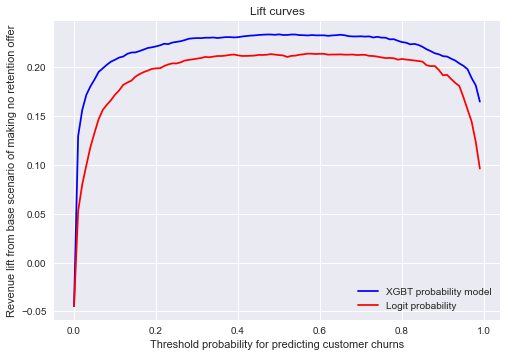

In [235]:
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['xgbt_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['XGBT probability model', 'Logit probability'])

In [236]:
# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test_sample, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

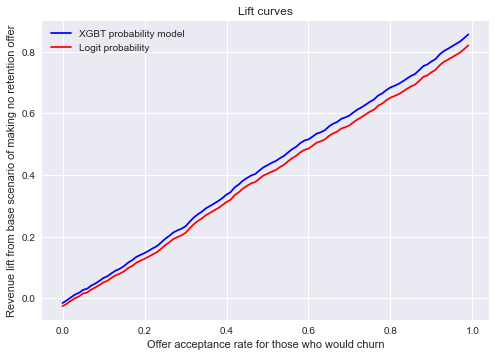

In [237]:
# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['xgbt_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['XGBT probability model', 'Logit probability'])

In [238]:
# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test_sample, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

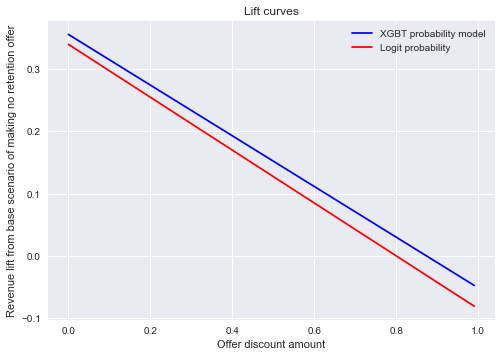

In [239]:
# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['xgbt_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['XGBT probability model', 'Logit probability'])

### relationship between discount and acceptence

In [243]:
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test_sample, threshold, base_price, t_discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind, t_acceptance_rate_churn

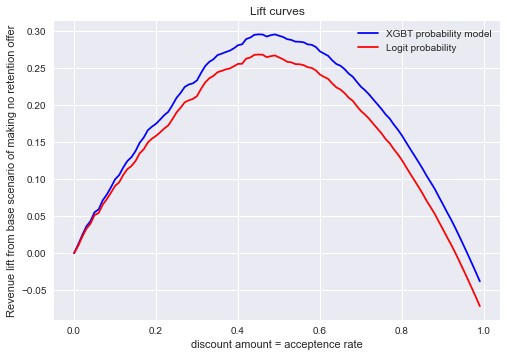

In [244]:
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['xgbt_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('discount amount = acceptence rate')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['XGBT probability model', 'Logit probability'])